In [1]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 3 - Fall 2025
## Due Sunday 12 Oct, 2025, 11:59 pm

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

For this assignment you may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

For this assignment, download some [sample Ka data](https://www.atmo.ttu.edu/bruning/5331/Ka2140614021408.RAWPXA9.nc). These data were converted directly from the raw format collected by the radar (Sigmet) to the [NetCDF CF/Radial standard](http://ncar.github.io/CfRadial/). No further processing has been applied. You do not have to include this file in your repository.

In the file, the radar variables (such as reflectivity) are stored in arrays with dimension `(time, range)`. At each time, a single ray of data is collected, which extends along range. There is also a `sweep` dimension that corresponds to a few different variables. These variables mark the start and the end of each radar scan. Let's look at that structure:

In [5]:
# Melodie Martinez
ds = xr.open_dataset('Ka2140614021408.RAWPXA9.nc', decode_timedelta=True)

print(ds)

# Print the first ten elevation angles.
print(ds.variables['elevation'][0:10])

# Shortcut to variable access
print(ds.elevation[0:10])
ds

<xarray.Dataset> Size: 98MB
Dimensions:                    (time: 2938, range: 1666, sweep: 5)
Coordinates:
  * time                       (time) datetime64[ns] 24kB 2014-06-14T02:14:19...
  * range                      (range) float32 7kB 0.0 15.0 ... 2.498e+04
    azimuth                    (time) float32 12kB ...
    elevation                  (time) float32 12kB ...
Dimensions without coordinates: sweep
Data variables: (12/25)
    total_power                (time, range) float32 20MB ...
    reflectivity               (time, range) float32 20MB ...
    velocity                   (time, range) float32 20MB ...
    spectrum_width             (time, range) float32 20MB ...
    normalized_coherent_power  (time, range) float32 20MB ...
    sweep_number               (sweep) int32 20B ...
    ...                         ...
    longitude                  float64 8B ...
    altitude                   float64 8B ...
    time_coverage_start        |S32 32B ...
    time_coverage_end         

<xarray.Dataset> Size: 98MB
Dimensions:                    (time: 2938, range: 1666, sweep: 5)
Coordinates:
  * time                       (time) datetime64[ns] 24kB 2014-06-14T02:14:19...
  * range                      (range) float32 7kB 0.0 15.0 ... 2.498e+04
    azimuth                    (time) float32 12kB ...
    elevation                  (time) float32 12kB ...
Dimensions without coordinates: sweep
Data variables: (12/25)
    total_power                (time, range) float32 20MB ...
    reflectivity               (time, range) float32 20MB ...
    velocity                   (time, range) float32 20MB ...
    spectrum_width             (time, range) float32 20MB ...
    normalized_coherent_power  (time, range) float32 20MB ...
    sweep_number               (sweep) int32 20B ...
    ...                         ...
    longitude                  float64 8B ...
    altitude                   float64 8B ...
    time_coverage_start        |S32 32B ...
    time_coverage_end          |S32 32B ...
    time_reference             |S32 32B ...
    volume_number              int32 4B ...
Attributes: (12/15)
    Conventions:             CF/Radial instrument_parameters
    version:                 1.3
    title:                   
    institution:             
    references:              
    source:                  
    ...                      ...
    sigmet_task_name:        TRANS_RHI   
    sigmet_extended_header:  false
    time_ordered:            none
    rays_missing:            67
    field_names:             total_power, reflectivity, velocity, spectrum_wi...
    history:

<xarray.DataArray 'sweep_mode' (sweep: 5)> Size: 160B
[5 values with dtype=|S32]
Dimensions without coordinates: sweep
Attributes:
    long_name:      Sweep mode
    units:          unitless
    standard_name:  sweep_mode
    comment:        Options are: "sector", "coplane", "rhi", "vertical_pointi...
<xarray.DataArray 'sweep_start_ray_index' (sweep: 5)> Size: 20B
[5 values with dtype=int32]
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of first ray in sweep, 0-based
    units:      count
<xarray.DataArray 'sweep_end_ray_index' (sweep: 5)> Size: 20B
[5 values with dtype=int32]
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of last ray in sweep, 0-based
    units:      count


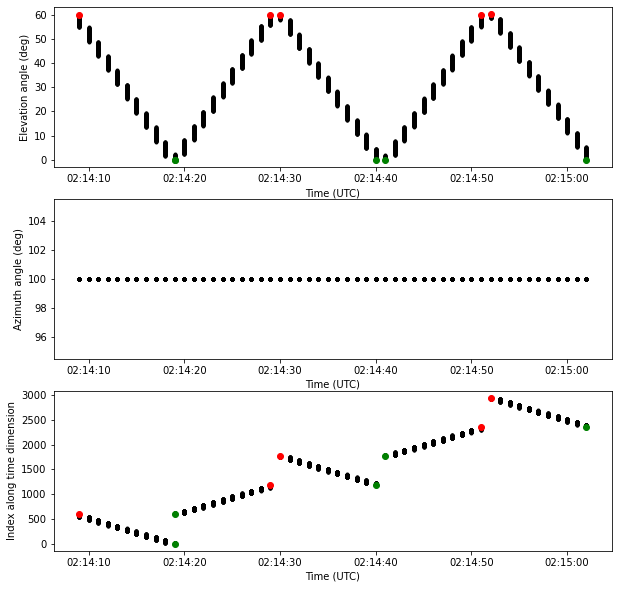

In [6]:
print(ds.sweep_mode)
print(ds.sweep_start_ray_index)
print(ds.sweep_end_ray_index)

az = ds.azimuth[:]
el = ds.elevation[:]
t = ds.time[:]
fig, axs = plt.subplots(3,1, squeeze=False, figsize=(10,10))

axs[0,0].plot(t,el, '.k')
axs[0,0].set_ylabel('Elevation angle (deg)')
axs[0,0].set_xlabel('Time (UTC)')
axs[1,0].plot(t,az, '.k')
axs[1,0].set_ylabel('Azimuth angle (deg)')
axs[1,0].set_xlabel('Time (UTC)')
axs[2,0].plot(t, np.arange(t.shape[0]), '.k')
axs[2,0].set_ylabel('Index along time dimension')
axs[2,0].set_xlabel('Time (UTC)')
for sw_start, sw_end in zip(ds.sweep_start_ray_index, ds.sweep_end_ray_index):
    axs[0,0].plot(t[sw_start], el[sw_start], marker='o', color='g')
    axs[0,0].plot(t[sw_end], el[sw_end], marker='o',color='r')
    axs[2,0].plot(t[sw_start], sw_start, marker='o', color='g')
    axs[2,0].plot(t[sw_end], sw_end, marker='o',color='r')

The green dots mark the start of a sweep according to `sweep_start_ray_index`, and red marks the end according to `sweep_end_ray_index`. We observe that:

0. the scans are in [RHI](http://ww2010.atmos.uiuc.edu/(Gh)/guides/rs/rad/basics/cnmods.rxml) mode, per the scan_mode variable.
1. the data have time precision of 1 s
2. the data are not stored in time order.
3. the data are stored in the file in order of increasing elevation angle, not increasing time.
4. azimuth angle is constant.

For the rest of this assignment, let's work with the second of the five scans, where time and elevation both increase with index along the time dimension. Reuse this variable instead of hard-coding a scan number in later code.

In [7]:
scan_idx = 1

**1.** Let's start by preparing the coordinates needed to plot a scan. Write a function that takes a radar dataset and scan index, and returns  2D arrays of ranges, azimuths, and elevations that correspond to the edges of each radar sample (a.k.a., each gate). Your function should return three separate 2D variables, as you see in the sample function call below. `coords_2d` should call another helper function, `spherical_coord_edges(d, scan_idx)` that returns the 1D coordinates along each coordinate direction for that sweep. I found it helpful to visualize how the coordinates were distributed in 2D a quick, unlableled plot of each coordinate: `plt.imshow(r)`.

Also print out the shapes of r, az, and el.

r_2d shape: (587, 1667), el_2d shape: (587, 1667), az_2d shape: (587, 1667)


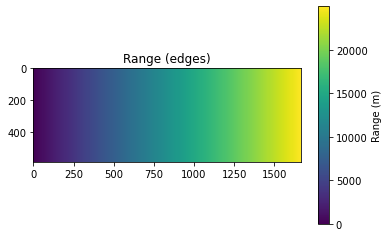

In [8]:
def spherical_coord_edges(ds, scan_idx): 
    """
    Returns 1D coord edges (r, az, elev) for the radar sweep.
    """
    
    # Start and end indices for the sweep
    sw_start= ds.sweep_start_ray_index[scan_idx].item()
    sw_end= ds.sweep_end_ray_index[scan_idx].item()
    
    # Selecting data
    r= ds['range'].values  # shape (n range)
    az= ds['azimuth'].values[sw_start:sw_end+1]   # shape (n rays)
    el= ds['elevation'].values[sw_start:sw_end+1] # shape (n_rays)
    
    # computing the edges by averaging neighbors and extending at both ends
    def edges_1d(x):
        x_mid= 0.5* (x[1:] +x[:-1])
        dx0= x_mid[0] -x[0]
        dxN= x[-1] -x_mid[-1]
        x_edges= np.concatenate(([x[0]-dx0], x_mid, [x[-1]+dxN]))
        return x_edges
    
    r_edges= edges_1d(r)
    az_edges= edges_1d(az)
    el_edges= edges_1d(el)
    
    # return values
    return r_edges, az_edges, el_edges


def coords_2d(ds, scan_idx):
    """
    Funct that takes radar dataset and scan index and returns ranges,
    azimuths, and elevations to correspond with the edges of each radar sample
    """
    
    r_edges, az_edges, el_edges= spherical_coord_edges(ds, scan_idx)
    
    # 2D arrays where range varies along horiz and elev along vert
    r_2d, el_2d= np.meshgrid(r_edges, el_edges)
    
    # Azimuth constant for RHI, 2D
    az_const= np.mean(az_edges) 
    az_2d= np.full_like(r_2d, az_const)
    
    print(f"r_2d shape: {r_2d.shape}, el_2d shape: {el_2d.shape}, az_2d shape: {az_2d.shape}")
    return r_2d, az_2d, el_2d

r, az, el= coords_2d(ds, scan_idx)

plt.imshow(r)
plt.title("Range (edges)")
plt.colorbar(label= "Range (m)")
plt.show()

**2.** Make a 4-panel plot of reflectivity, velocity, spectrum width, and normalized coherent power. Use `coordinateSystems.RadarCoordinateSystem` together with a tangent plane system to plot in altitude above vs. range along a tangent plane. The tangent plane should be centered at the location of radar. You will need to definte a new variable that gives range along the tangent plane.

Note that if you find that the coordinate transformations fail to preserve the shape of your input coordinate arrays, you can fix it with `X.shape = r.shape`, where `X` has been transformed from `r`.

C:\Users\melmo\AppData\Local\Temp\ipykernel_64080\1920206881.py:54: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm= ax.pcolormesh(x_tplane/1000, z_tplane/1000, data, shading= 'auto') # (km)


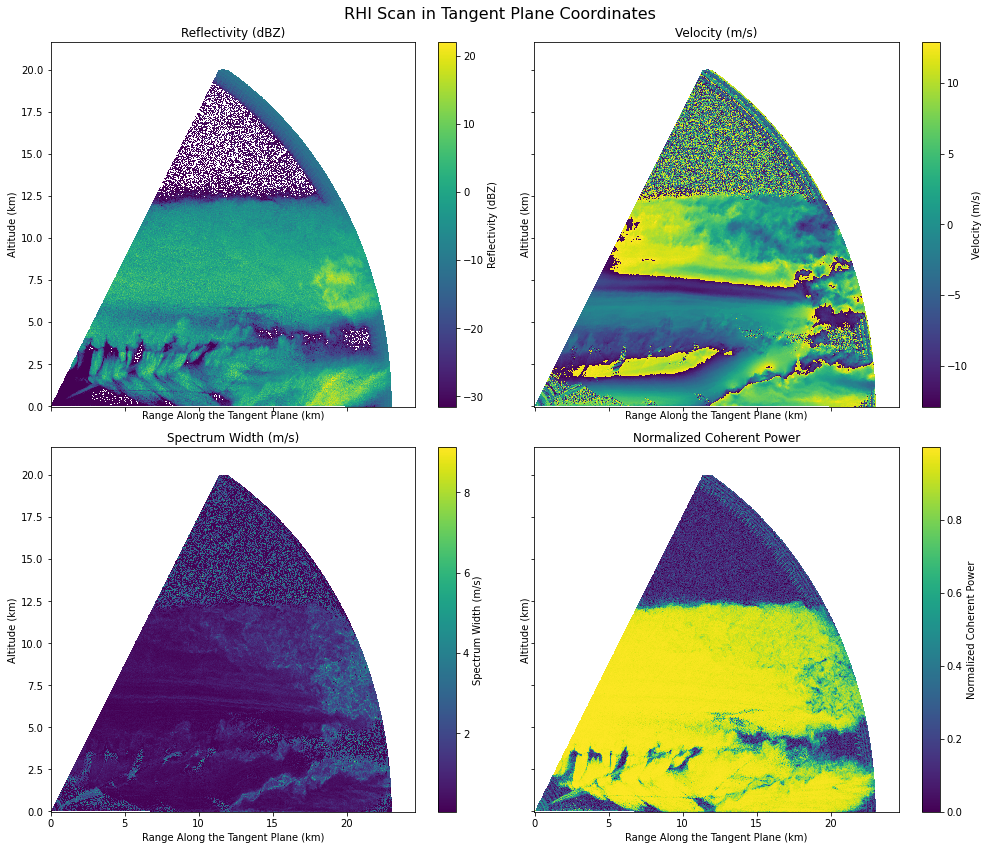

In [10]:
from coords import RadarCoordinateSystem, TangentPlaneCartesianSystem

# Radar location
radar_lat= ds.latitude.values
radar_lon= ds.longitude.values
radar_alt= ds.altitude.values

# coord systems
radar= RadarCoordinateSystem(radar_lat, radar_lon, radar_alt)
tangent= TangentPlaneCartesianSystem(radar_lat, radar_lon, radar_alt)

# Extracting the sweep data
sw_start= ds.sweep_start_ray_index[scan_idx].item()
sw_end= ds.sweep_end_ray_index[scan_idx].item()

# Each variable has (time, range)
ref= ds['reflectivity'].isel(time= slice(sw_start, sw_end+1))     # reflectivity
vel= ds['velocity'].isel(time= slice(sw_start, sw_end+1))     # velocity
swidth= ds['spectrum_width'].isel(time= slice(sw_start, sw_end+1)) # spec width
ncp= ds['normalized_coherent_power'].isel(time= slice(sw_start, sw_end+1))     # norm coherent pwr

# RHI coord grids
r= ds.range.values
az= ds.azimuth.values[sw_start:sw_end+1]
el= ds.elevation.values[sw_start:sw_end+1]

# 2d coord grids for RHI scan, azimuth constant and elev varies
r_2d, el_2d= np.meshgrid(r, el)

# Fixed azimuth!!
az_fixed= np.median(az)
az_2d= np.ones_like(r_2d)*az_fixed

# Converting spherical to Cartesian (ECEF)
X, Y, Z= radar.toECEF(r_2d, az_2d, el_2d) 

# Then converting Cart (ECEF) to tan plane coords
x_tplane, y_tplane, z_tplane= tangent.fromECEF(X, Y, Z)

# Fixing any shaping mismatches
x_tplane.shape= r_2d.shape          #range along tan plane
y_tplane.shape= r_2d.shape          #horizontal
z_tplane.shape= r_2d.shape          # altitude above the radar

# Four panel plot
fig, axs= plt.subplots(2, 2, figsize= (14, 12), sharex= True, sharey= True)
axs= axs.ravel()

# data for iteration
data_arrays= [ref, vel, swidth, ncp]
titles= ['Reflectivity (dBZ)', 'Velocity (m/s)', 'Spectrum Width (m/s)', 'Normalized Coherent Power']

for ax, data, title in zip(axs, data_arrays, titles):
    pcm= ax.pcolormesh(x_tplane/1000, z_tplane/1000, data, shading= 'auto') # (km)
    fig.colorbar(pcm, ax= ax, orientation= 'vertical', label= title)
    ax.set_title(title)
    ax.set_xlabel('Range Along the Tangent Plane (km)')
    ax.set_ylabel('Altitude (km)')
    
fig.suptitle("RHI Scan in Tangent Plane Coordinates", fontsize= 16)    
plt.tight_layout()
plt.show()

**3.** Repeat the plot for question 2, but for an aziuthal equidistant map projection centered at the radar location.

As above, you will to definte a new variable that gives a horizontal distance (a sort of "range") using the coordinates returned from the map projection. This can be calculated in one line of code.

How does this plot compare to the plot defined in tangent plane coordinates?

C:\Users\melmo\AppData\Local\Temp\ipykernel_64080\1248605347.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X/1000, z/1000, ref, cmap= 'turbo', shading= 'auto')


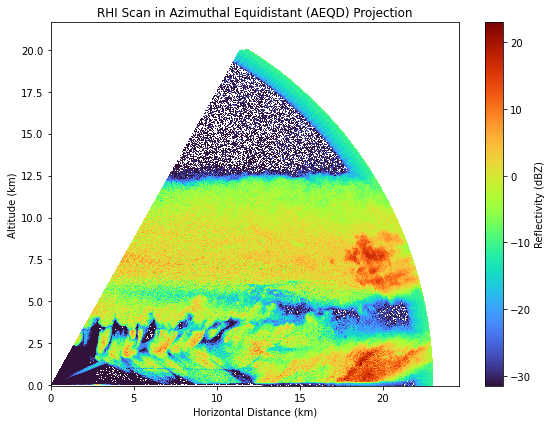

<xarray.DataArray 'latitude' ()> Size: 8B
array(34.72259)
Attributes:
    long_name:      Latitude
    units:          degrees_north
    standard_name:  Latitude
<xarray.DataArray 'longitude' ()> Size: 8B
array(-76.74685)
Attributes:
    long_name:      Longitude
    units:          degrees_east
    standard_name:  Longitude
<xarray.DataArray 'range' ()> Size: 4B
array(15., dtype=float32)


In [11]:
# Where is the radar? What is its gate spacing?from pyproj import Proj

from pyproj import Proj
aeqd= Proj(proj= 'aeqd', lat_0= radar_lat, lon_0= radar_lon, datum= 'WGS84')

scan_idx= 0
sw_start= ds.sweep_start_ray_index[scan_idx].item()
sw_end= ds.sweep_end_ray_index[scan_idx].item()

ref= ds['reflectivity'].isel(time=slice(sw_start, sw_end+1))
az= ds['azimuth'].isel(time=slice(sw_start, sw_end+1))
el= ds['elevation'].isel(time=slice(sw_start, sw_end+1))
r= ds['range']

# compute slant coords
R, E= np.meshgrid(r, np.deg2rad(el))
x= R*np.cos(E) 
z= R*np.sin(E)  # height

# Converting horiz dist x and azimuth to projected map coords
azi_rad_2d= np.deg2rad(az.values)[:, np.newaxis]  # shape (n_rays, 1)
X= x*np.sin(azi_rad_2d)    # E/W dist (m)
Y= x*np.cos(azi_rad_2d)    # N/S dist (m)

plt.figure(figsize= (8, 6))
plt.pcolormesh(X/1000, z/1000, ref, cmap= 'turbo', shading= 'auto')
plt.xlabel('Horizontal Distance (km)')
plt.ylabel('Altitude (km)')
plt.title('RHI Scan in Azimuthal Equidistant (AEQD) Projection')
plt.colorbar(label= 'Reflectivity (dBZ)')
plt.tight_layout()
plt.show()

print(ds.latitude)
print(ds.longitude)
print(ds.range[1]-ds.range[0])

To set the stage for the next two assignments, let's say we want to oversample the 15 m range gates to a 5 m carteisian grid in the domain 9.0…9.5 km range and 2.9…3.4 km altitude. Once again, we will use the distance above and the range along the tangent plane.

**4.** Create 2D arrays giving the corresponding center locations for each desired analysis location. Start with 1D grid box edges spanning the range above.

In [12]:
# defining range (x) and alt (z) in km
x_min, x_max= 9.0, 9.5
z_min, z_max= 2.9, 3.4

# grid spacing (km)
dx= dz= 0.005  # (5m)

# 1D edges 
x_edges= np.arange(x_min, x_max+dx, dx)
z_edges= np.arange(z_min, z_max+dz, dz)

# Centers (midpt)
x_centers= 0.5*(x_edges[:-1]+x_edges[1:])
z_centers= 0.5*(z_edges[:-1]+z_edges[1:])

print(f"x_edges: {x_edges.shape}, z_edges: {z_edges.shape}")
print(f"x_centers: {x_centers.shape}, z_centers: {z_centers.shape}")

#2D grids for Cart grid centers
X_c, Z_c= np.meshgrid(x_centers, z_centers)

print("X_c shape:", X_c.shape)
print("Z_c shape:", Z_c.shape)

x_edges: (102,), z_edges: (101,)
x_centers: (101,), z_centers: (100,)
X_c shape: (100, 101)
Z_c shape: (100, 101)


**5.** For the next question, we will interpolate in three ways:
- nearest neighbor
- linear
- the traditional meteorological "Barnes" analysis (which is really a Gaussian blur fliter). 

To do so, we will use MetPy's built-in interpolators. It wraps SciPy's built-in nearest and linear interpolation methods, and adds Barnes, natural neighbor, and other interpolators. 

You will probably need to install metpy with `conda install -c conda-forge metpy`.

Once you have installed MetPy, use its `interpolate_to_points` function. Note that it takes three arguments, and those arguments require that you use `np.vstack` to rearrange the locations and data into the correct shape. Where necessary you can use `flatten` to produce the sequence of 1D coordinate arrays accepted by `vstack`.

So that the Barnes analysis doesn't take forever, you will want to subset the data to only those locations that overlap with the analysis grid.

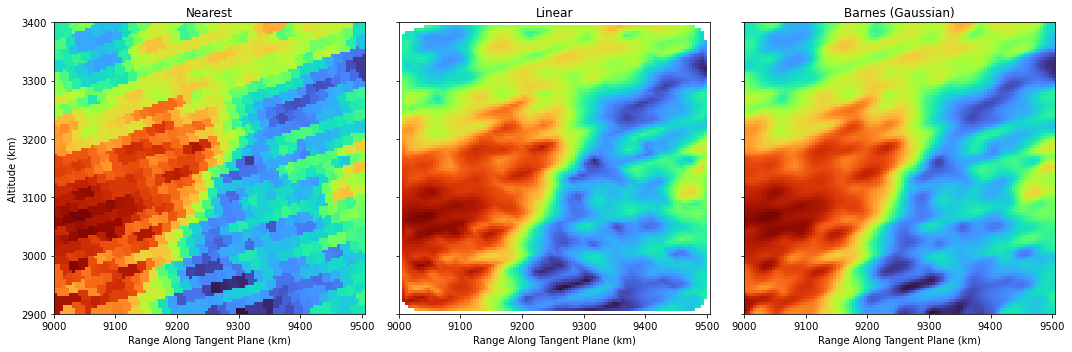

In [13]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator, griddata
from metpy.units import units
from metpy.interpolate import interpolate_to_points

X_c_m= X_c*1000
Z_c_m= Z_c*1000

# Trimming refl to match tan plane coord shapes
ref_trim= ref.values[:x_tplane.shape[0], :x_tplane.shape[1]]

#limiting to points near the target grid domain
mask= ((x_tplane>= X_c_m.min()) & (x_tplane<= X_c_m.max()) &
       (z_tplane>= Z_c_m.min()) & (z_tplane<= Z_c_m.max()))

# Source known points
src_pts= np.vstack((x_tplane[mask].ravel(), z_tplane[mask].ravel())).T
src_vals= ref_trim[mask].ravel()

# Target (analysis) points
targ_pts= np.vstack((X_c_m.ravel(), Z_c_m.ravel())).T

# Interpolations
# Nearest
ref_nearest= interpolate_to_points(src_pts, src_vals, targ_pts, interp_type= 'nearest')

# Linear
ref_linear= interpolate_to_points(src_pts, src_vals, targ_pts, interp_type= 'linear')

# Barnes (Gaussian blur)
ref_barnes= interpolate_to_points(src_pts, src_vals, targ_pts, interp_type= 'barnes', search_radius= 200.0)

# Reshaping to grid
ref_nearest_2d= ref_nearest.reshape(X_c_m.shape)
ref_linear_2d= ref_linear.reshape(X_c_m.shape)
ref_barnes_2d= ref_barnes.reshape(X_c_m.shape)

# Plots
fig, axs= plt.subplots(1, 3, figsize= (15, 5), sharey= True)
for ax, data, title in zip(axs, [ref_nearest_2d, ref_linear_2d, ref_barnes_2d],
                           ['Nearest', 'Linear', 'Barnes (Gaussian)']):
    pcm= ax.pcolormesh(X_c_m, Z_c_m, data, shading= 'auto', cmap= 'turbo')
    ax.set_title(title)
    ax.set_xlabel('Range Along Tangent Plane (km)')
axs[0].set_ylabel('Altitude (km)')
plt.tight_layout()
plt.show()

**6.** Make a plot of the original data and the three interpolation methods. Compared to the original data, what do the three interpolation methods do to the data? Think about what you would regard as desirable properties of an analysis.

**Some demonstration code** showing some useful array tricks is provided below.

C:\Users\melmo\AppData\Local\Temp\ipykernel_64080\2025792845.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm0= axs[0].pcolormesh(x_tplane/1000, z_tplane/1000, ref_trim, shading= 'auto', cmap= 'turbo')


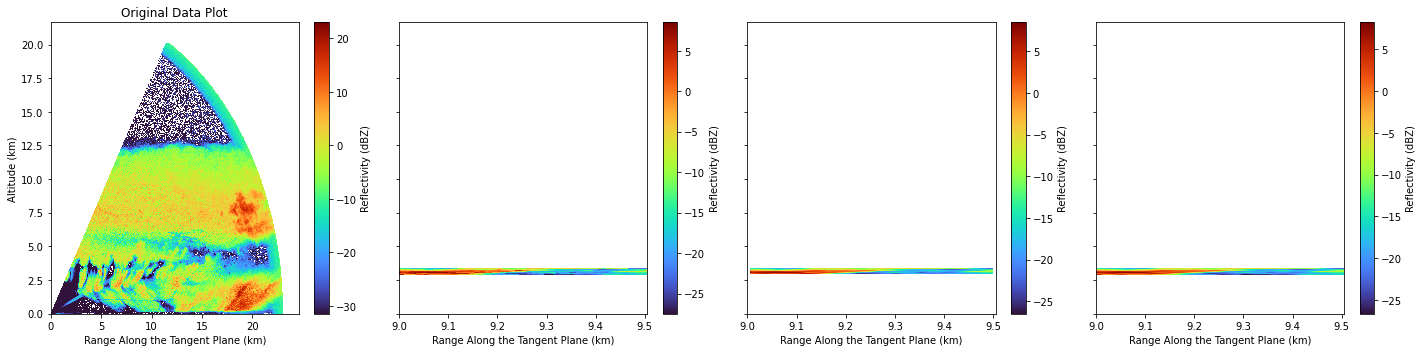

In [14]:
# plot og data and three interpolation methods
fig, axs= plt.subplots(1, 4, figsize= (20, 5), sharey=True)

# Og data plot
pcm0= axs[0].pcolormesh(x_tplane/1000, z_tplane/1000, ref_trim, shading= 'auto', cmap= 'turbo')
axs[0].set_title('Original Data Plot')
axs[0].set_xlabel('Range Along the Tangent Plane (km)')
axs[0].set_ylabel('Altitude (km)')
fig.colorbar(pcm0, ax= axs[0], label= 'Reflectivity (dBZ)')

# 3 interpolated data plots
for ax, data, title in zip(axs[1:], [ref_nearest_2d, ref_linear_2d, ref_barnes_2d],
                           ['Nearest', 'Linear', 'Barnes (Gaussian)']):
    pcm= ax.pcolormesh(X_c_m/1000, Z_c_m/1000, data, shading= 'auto', cmap= 'turbo')
    ax.set_xlabel('Range Along the Tangent Plane (km)')
    fig.colorbar(pcm, ax=ax, label= 'Reflectivity (dBZ)')
    
plt.tight_layout()
plt.show()

In the original plot, we see the classic radar arc sweep meteorologists are used to. In the interpolated plots, we see the data and the figures flattened into a single line towards the bottom of the plots. In the original plot, we see the elevation angle along with an arc, showing Polar coordinates. On the other hand, the interpolated plots are plotted into Cartesian coordinates. Since these two are different, we clearly see one plot meant for radars, and the other one is harder to analyze since it's only a cross-section of a single elevation. 

In [ ]:
import numpy as np

In [ ]:
np.vstack?

In [ ]:
a = np.array([1,2,3])
b = np.array([3,4,5])

In [ ]:
a

In [ ]:
b

In [ ]:
s=np.vstack((a,b))

In [ ]:
s

In [ ]:
s.shape

In [ ]:
s.T

In [ ]:
z=np.ones_like(s.T)

In [ ]:
z.flatten()

In [ ]:
np.hstack((a,b))

In [ ]:
z.shape

In [ ]:
np.hstack((z[:,0], z[:,1]))

In [ ]:
a[None,:].shape

In [ ]:
b[:,None].shape

In [ ]:
sq = a[None,:]*b[:,None]
sq

In [ ]:
sel = (sq > 5) & (sq <=10)
sel

In [ ]:
np.argmin(sq)

In [ ]:
np.where(sel)

In [ ]:
np.where?

In [ ]:
ds

In [ ]:
r_cond = (ds.range > 5000) & (ds.range < 10000)
sweep_cond = ((ds.sweep >= 2) & (ds.sweep <=4))

ds[ {'range':r_cond, 'sweep':sweep_cond} ]